# Predicting the Next Hit Movie

**Objective**: Create a machine learning model to predict the next AAA movie

**Data Source**: [IMDB Dataset](https://datasets.imdbws.com/) (Accessed and downloaded on 6/19/2024)

## INSERT AN INTRO HERE LIKE WHAT MODELS USED AND SUMMARY OF WHAT HAPPENS TO THE DATA

### Data Cleaning and Feature Engineering

In the code below we access the tsv files. Since title.episode.tsv, focuses on different TV Series then we do not need it in our data. title.akas.tsv was also excluded since it only gives more information about the local title in the region.

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

In [1]:
# Define the paths to your data files
data_folder = 'Data'

files = {
    'name_basics': os.path.join(data_folder, 'name.basics.tsv/name.basics.tsv'),
    'title_basics': os.path.join(data_folder, 'title.basics.tsv/title.basics.tsv'),
    'title_crew': os.path.join(data_folder, 'title.crew.tsv/title.crew.tsv'),
    'title_principals': os.path.join(data_folder, 'title.principals.tsv/title.principals.tsv'),
    'title_ratings': os.path.join(data_folder, 'title.ratings.tsv/title.ratings.tsv')
}

# Load the data into pandas dataframes
name_basics = pd.read_csv(files['name_basics'], sep='\t')
title_basics = pd.read_csv(files['title_basics'], sep='\t')
title_crew = pd.read_csv(files['title_crew'], sep='\t')
title_principals = pd.read_csv(files['title_principals'], sep='\t')
title_ratings = pd.read_csv(files['title_ratings'], sep='\t')

C:\Users\Ayisha\AppData\Local\Temp\ipykernel_18872\2653193819.py:17: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  title_basics = pd.read_csv(files['title_basics'], sep='\t')


In [2]:
# List of DataFrames
dataframes = {
    'name_basics': name_basics,
    'title_basics': title_basics,
    'title_crew': title_crew,
    'title_principals': title_principals,
    'title_ratings': title_ratings
}

#### Checking for null values and duplicated data

In [3]:
# Function to display basic information about the dataset
def profile_data(df, name):
    print(f"--- {name} ---")
    print(df.info())
    print(df.describe(include='all'))
    print("\nMissing values:\n", df.isnull().sum())
    print("\n")

# Profile each dataset
for name, df in dataframes.items():
    profile_data(df, name)


--- name_basics ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13578126 entries, 0 to 13578125
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   nconst             object
 1   primaryName        object
 2   birthYear          object
 3   deathYear          object
 4   primaryProfession  object
 5   knownForTitles     object
dtypes: object(6)
memory usage: 621.6+ MB
None
           nconst primaryName birthYear deathYear primaryProfession  \
count    13578126    13578118  13578126  13578126          13578126   
unique   13578126    10453111       541       485             22904   
top     nm0000001        Alex        \N        \N                \N   
freq            1         496  12960589  13348312           2612196   

       knownForTitles  
count        13578126  
unique        5674234  
top                \N  
freq          1502159  

Missing values:
 nconst               0
primaryName          8
birthYear            0
deathYea

In [4]:
# Function to check for duplicates by comparing entire rows
def check_row_duplicates(df):
    # Check for duplicate rows
    duplicates = df[df.duplicated(keep=False)]
    return duplicates

# Iterate through each DataFrame and check for duplicates
for name, df in dataframes.items():
    duplicates = check_row_duplicates(df)
    if not duplicates.empty:
        print(f"Duplicates in {name}:")
        print(duplicates)
    else:
        print(f"No duplicates in {name}")

No duplicates in name_basics
No duplicates in title_basics
No duplicates in title_crew
No duplicates in title_principals
No duplicates in title_ratings


Based on the documentation, title_basics would contain the titles which are movies and which aren't, so the first step would be to get the titles that are movies.

In [5]:
title_basics['titleType'].unique()

array(['short', 'movie', 'tvShort', 'tvMovie', 'tvSeries', 'tvEpisode',
       'tvMiniSeries', 'tvSpecial', 'video', 'videoGame', 'tvPilot'],
      dtype=object)

Since there are two types of movies, they will both be considered in the cut down dataframe below.

In [6]:
movies_df = title_basics[(title_basics['titleType'] == 'movie') | (title_basics['titleType'] == 'tvMovie')]

movies_df is then merged with title_ratings and title_crew. We then add more columns for the number of directors and writers the movie has. 

In [7]:
# Merge title_basics with title_ratings
movies_df = movies_df.merge(title_ratings, on='tconst', how='left')

In [8]:
# Merge movies_df with title_crew
movies_df = movies_df.merge(title_crew, on='tconst', how='left')

In [9]:
# Count the number of directors and writers
movies_df['num_directors'] = movies_df['directors'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)
movies_df['num_writers'] = movies_df['writers'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)

<!-- In name_basics, we then add a column for the number of known titles the person is known for and the average of the ratings of the movies they have contributed to.
# Calculate the number of known titles
name_basics['num_known_titles'] = name_basics['knownForTitles'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)

# Merge name_basics with title_ratings to calculate average rating of known titles
name_known_titles = name_basics[['nconst', 'knownForTitles']].copy()
name_known_titles = name_known_titles.dropna(subset=['knownForTitles'])
name_known_titles = name_known_titles.assign(knownForTitles=name_known_titles['knownForTitles'].str.split(',')).explode('knownForTitles')

# Merge with title_ratings
name_known_titles = name_known_titles.merge(title_ratings, left_on='knownForTitles', right_on='tconst', how='left')
name_known_titles_grouped = name_known_titles.groupby('nconst')['averageRating'].mean().reset_index()
name_known_titles_grouped.rename(columns={'averageRating': 'avg_known_title_rating'}, inplace=True)

# Merge back to name_basics
name_basics = name_basics.merge(name_known_titles_grouped, on='nconst', how='left')
name_basics['avg_known_title_rating'].fillna(0, inplace=True)
-->

Upon checking the movies_df dataframe below, we can still remove some columns like endYear.

In [11]:
movies_df

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,directors,writers,num_directors,num_writers
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,5.4,212.0,nm0085156,nm0085156,1,1
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"Documentary,News,Sport",5.2,517.0,nm0714557,\N,1,1
2,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,4.4,17.0,nm0063413,"nm0063413,nm0657268,nm0675388",1,3
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography",6.0,910.0,nm0846879,nm0846879,1,1
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama,5.7,25.0,nm0141150,nm0141150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832113,tt9916680,movie,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,0,2007,\N,100,Documentary,NaN,NaN,nm0652213,"nm0652213,nm10538576",1,2
832114,tt9916692,tvMovie,Teatroteka: Czlowiek bez twarzy,Teatroteka: Czlowiek bez twarzy,0,2015,\N,66,Drama,NaN,NaN,nm10538592,nm10538592,1,1
832115,tt9916706,movie,Dankyavar Danka,Dankyavar Danka,0,2013,\N,\N,Comedy,7.6,5.0,nm7764440,nm7933903,1,1
832116,tt9916730,movie,6 Gunn,6 Gunn,0,2017,\N,116,Drama,7.0,12.0,nm10538612,nm10538612,1,1


In [12]:
movies_df.drop(columns='endYear', inplace=True)

Afterwards, we save the new dataframe so that it is easier to load the data.

In [13]:
movies_df.to_csv('movies_df_06192024.tsv', sep='\t', index=False)

In [24]:
dtype = {'tconst': str, 'titleType': str, 'primaryTitle': str, 'originalTitle': str, 'startYear': str, 'directors': str, 'writers': str}  # Replace 'column_name1', 'column_name2', etc., with actual column names
movies_df = pd.read_csv('movies_df_06192024.tsv', sep='\t', dtype=dtype)

In [25]:
movies_df

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,directors,writers,num_directors,num_writers
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,45,Romance,5.4,212.0,nm0085156,nm0085156,1,1
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,100,"Documentary,News,Sport",5.2,517.0,nm0714557,\N,1,1
2,tt0000502,movie,Bohemios,Bohemios,0,1905,100,\N,4.4,17.0,nm0063413,"nm0063413,nm0657268,nm0675388",1,3
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,70,"Action,Adventure,Biography",6.0,910.0,nm0846879,nm0846879,1,1
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,90,Drama,5.7,25.0,nm0141150,nm0141150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832113,tt9916680,movie,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,0,2007,100,Documentary,NaN,NaN,nm0652213,"nm0652213,nm10538576",1,2
832114,tt9916692,tvMovie,Teatroteka: Czlowiek bez twarzy,Teatroteka: Czlowiek bez twarzy,0,2015,66,Drama,NaN,NaN,nm10538592,nm10538592,1,1
832115,tt9916706,movie,Dankyavar Danka,Dankyavar Danka,0,2013,\N,Comedy,7.6,5.0,nm7764440,nm7933903,1,1
832116,tt9916730,movie,6 Gunn,6 Gunn,0,2017,116,Drama,7.0,12.0,nm10538612,nm10538612,1,1


We want to take a look into what data type each column is and correct them if it is wrong.

In [26]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832118 entries, 0 to 832117
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          832118 non-null  object 
 1   titleType       832118 non-null  object 
 2   primaryTitle    832116 non-null  object 
 3   originalTitle   832116 non-null  object 
 4   isAdult         832118 non-null  int64  
 5   startYear       832118 non-null  object 
 6   runtimeMinutes  832118 non-null  object 
 7   genres          832118 non-null  object 
 8   averageRating   364864 non-null  float64
 9   numVotes        364864 non-null  float64
 10  directors       811854 non-null  object 
 11  writers         811854 non-null  object 
 12  num_directors   832118 non-null  int64  
 13  num_writers     832118 non-null  int64  
dtypes: float64(2), int64(3), object(9)
memory usage: 88.9+ MB


In [27]:
movies_df.loc[movies_df['runtimeMinutes'] == '\\N', 'runtimeMinutes'] = 0
movies_df.loc[:, 'runtimeMinutes'] = movies_df['runtimeMinutes'].astype(int)

In [28]:
movies_df = movies_df.dropna(subset=['averageRating', 'numVotes'])

In [29]:
movies_df.replace('\\N', np.nan, inplace=True)

C:\Users\Ayisha\AppData\Local\Temp\ipykernel_19848\3310923245.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df.replace('\\N', np.nan, inplace=True)


We then look into the number of null values per column. Below we can see that the averageRating and numVotes column has a number of 467,254 null values, so we will proceed to remove those columns from our dataset to reduce bias and make sure that we still have a good representation of our data.

In [30]:
null_values_per_column = movies_df.isnull().sum()
print(null_values_per_column)

tconst                0
titleType             0
primaryTitle          0
originalTitle         0
isAdult               0
startYear            40
runtimeMinutes        0
genres            11603
averageRating         0
numVotes              0
directors          6976
writers           48234
num_directors         0
num_writers           0
dtype: int64


In [31]:
movies_df['startYear'].fillna('Unknown', inplace=True)
movies_df['directors'].fillna('Unknown', inplace=True)
movies_df['writers'].fillna('Unknown', inplace=True)

C:\Users\Ayisha\AppData\Local\Temp\ipykernel_19848\1551912280.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df['startYear'].fillna('Unknown', inplace=True)
C:\Users\Ayisha\AppData\Local\Temp\ipykernel_19848\1551912280.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df['directors'].fillna('Unknown', inplace=True)
C:\Users\Ayisha\AppData\Local\Temp\ipykernel_19848\1551912280.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

Below we normalize the data so that big values will not influence the outcome of the model.

In [32]:
# Features to scale
features_to_scale = ['runtimeMinutes', 'numVotes', 'num_directors', 'num_writers']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
movies_df.loc[:, features_to_scale] = scaler.fit_transform(movies_df[features_to_scale])

# Display to verify changes
movies_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,directors,writers,num_directors,num_writers
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,-0.306890,Romance,5.4,-0.087373,nm0085156,nm0085156,-0.171826,-0.626994
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,0.141848,"Documentary,News,Sport",5.2,-0.078268,nm0714557,Unknown,-0.171826,-0.626994
2,tt0000502,movie,Bohemios,Bohemios,0,1905,0.141848,NaN,4.4,-0.093195,nm0063413,"nm0063413,nm0657268,nm0675388",-0.171826,0.979718
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,-0.102918,"Action,Adventure,Biography",6.0,-0.066535,nm0846879,nm0846879,-0.171826,-0.626994
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,0.060259,Drama,5.7,-0.092956,nm0141150,nm0141150,-0.171826,-0.626994


In [11]:
movies_df.to_csv('movies_df_06202024.tsv', sep='\t', index=False)

In [33]:
dtype = {'tconst': str, 'titleType': str, 'primaryTitle': str, 'originalTitle': str, 'startYear': str, 'directors': str, 'writers': str}  # Replace 'column_name1', 'column_name2', etc., with actual column names
movies_df = pd.read_csv('movies_df_06202024.tsv', sep='\t', dtype=dtype)

Next, we do one-hot encoding for genres.

In [13]:
# Split genres into multiple rows
# Separate the genres column and explode it
data_exploded = movies_df[['tconst', 'genres']].copy()
data_exploded['genres'] = data_exploded['genres'].str.split(',')
data_exploded = data_exploded.explode('genres')

In [14]:
# One-hot encode the genres
genres_encoded = pd.get_dummies(data_exploded['genres'], prefix='genre')

In [15]:
# Aggregate the one-hot encoded genres back to the original DataFrame
genre_data = data_exploded[['tconst']].join(genres_encoded).groupby('tconst').max().reset_index()

In [16]:
# Merge the one-hot encoded genres with the original data
movies_df = movies_df.drop(columns=['genres'])
movies_df = movies_df.merge(genre_data, on='tconst', how='left')

In [17]:
movies_df

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,averageRating,numVotes,directors,...,genre_Mystery,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Talk-Show,genre_Thriller,genre_War,genre_Western
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,-0.306890,5.4,-0.087373,nm0085156,...,False,False,False,True,False,False,False,False,False,False
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,0.141848,5.2,-0.078268,nm0714557,...,False,True,False,False,False,True,False,False,False,False
2,tt0000502,movie,Bohemios,Bohemios,0,1905,0.141848,4.4,-0.093195,nm0063413,...,False,False,False,False,False,False,False,False,False,False
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,-0.102918,6.0,-0.066535,nm0846879,...,False,False,False,False,False,False,False,False,False,False
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,0.060259,5.7,-0.092956,nm0141150,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364859,tt9916428,movie,The Secret of China,Hong xing zhao yao Zhong guo,0,2019,-0.674039,3.6,-0.093135,nm0910951,...,False,False,False,False,False,False,False,False,True,False
364860,tt9916460,tvMovie,Pink Taxi,Pink Taxi,0,2019,-0.674039,8.9,-0.093135,nm7048843,...,False,False,False,False,False,False,False,False,False,False
364861,tt9916538,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,0,2019,0.329502,8.3,-0.093434,nm4457074,...,False,False,False,False,False,False,False,False,False,False
364862,tt9916706,movie,Dankyavar Danka,Dankyavar Danka,0,2013,-0.674039,7.6,-0.093553,nm7764440,...,False,False,False,False,False,False,False,False,False,False


Since we want to classify what movie would be the next hit based on ratings, we can assume that if a movie has a rating of 7 or above then it is a hit. Thus, we make a new column called isAHit.

In [18]:
movies_df['isAHit'] = (movies_df['averageRating'] >= 7.0).astype(int)

In [19]:
movies_df.to_csv('movies_df_06212024.tsv', sep='\t', index=False)

#### Dataset Summary

<INSRT HERE SUMMARY OF WHAT MOVIES_DF IS AND THE DIFF COLUMNS IT HAS AND WHAT THE COLULMNS ARE ABOUT, specify also which ones are additions>

<!-- # import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Calculate the correlation matrix
# correlation_matrix = movies_df[initial_feature_cols + [target_col]].corr()

# # Plot the heatmap of the correlation matrix
# plt.figure(figsize=(26, 10))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# plt.show()

# # Select features with high correlation to the target variable
# correlation_threshold = 0.1  
# relevant_features = correlation_matrix[target_col][abs(correlation_matrix[target_col]) > correlation_threshold].index.tolist()
# relevant_features.remove(target_col)

# print("Selected features based on correlation:", relevant_features)-->

### Model Training Preparation

## DO THE RANDOM SAMPLING HERE AND JUSTIFY NA ITS BC THE DATASET IS TOO BIG

In [4]:
dtype = {'tconst': str, 'titleType': str, 'primaryTitle': str, 'originalTitle': str, 'startYear': str, 'directors': str, 'writers': str}
movies_df = pd.read_csv('movies_df_06212024.tsv', sep='\t', dtype=dtype)
movies_df_sample = movies_df.sample(n=50000, random_state=42)
movies_df_sample.to_csv('movies_df_sampled.tsv', sep='\t', index=False)

In [8]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

In [9]:
dtype = {'tconst': str, 'titleType': str, 'primaryTitle': str, 'originalTitle': str, 'startYear': str, 'directors': str, 'writers': str}
movies_df = pd.read_csv('movies_df_sampled.tsv', sep='\t', dtype=dtype)

In [10]:
# Define feature columns and target column
target_col = 'isAHit'
feature_cols = ['isAdult', 'runtimeMinutes', 'numVotes', 'num_directors', 'num_writers'] + [col for col in movies_df.columns if col.startswith('genre_')]

In [11]:
# Use the selected features for modeling
X = movies_df[feature_cols]
y = movies_df[target_col]

In [12]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Verify that the feature selection and preprocessing steps are correctly applied
print("Training features:", X_train.columns)
print("Testing features:", X_test.columns)

Training features: Index(['isAdult', 'runtimeMinutes', 'numVotes', 'num_directors', 'num_writers',
       'genre_Action', 'genre_Adult', 'genre_Adventure', 'genre_Animation',
       'genre_Biography', 'genre_Comedy', 'genre_Crime', 'genre_Documentary',
       'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_Film-Noir',
       'genre_Game-Show', 'genre_History', 'genre_Horror', 'genre_Music',
       'genre_Musical', 'genre_Mystery', 'genre_News', 'genre_Reality-TV',
       'genre_Romance', 'genre_Sci-Fi', 'genre_Sport', 'genre_Talk-Show',
       'genre_Thriller', 'genre_War', 'genre_Western'],
      dtype='object')
Testing features: Index(['isAdult', 'runtimeMinutes', 'numVotes', 'num_directors', 'num_writers',
       'genre_Action', 'genre_Adult', 'genre_Adventure', 'genre_Animation',
       'genre_Biography', 'genre_Comedy', 'genre_Crime', 'genre_Documentary',
       'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_Film-Noir',
       'genre_Game-Show', 'genre_History', 'ge

### Logistic Regression

In [14]:
# Logistic Regression with hyperparameter tuning
log_reg = LogisticRegression(max_iter=5000, solver='saga')

Below we do hyperparameter tuning to find the best set of parameters for our model.

In [15]:
# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
}

# Grid search 
grid_search_log_reg = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
grid_search_log_reg.fit(X_train, y_train)

In [ ]:
# Best parameters and score
print("Best parameters for Logistic Regression: ", grid_search_log_reg.best_params_)
print("Best cross-validation accuracy: ", grid_search_log_reg.best_score_)

# Predict and evaluate on the test set
y_pred_log_reg = grid_search_log_reg.predict(X_test)
print("Test Accuracy: ", accuracy_score(y_test, y_pred_log_reg))
print("Classification Report: \n", classification_report(y_test, y_pred_log_reg))

Best parameters for Logistic Regression:  {'C': 1, 'penalty': 'l1'}
Best cross-validation accuracy:  0.7384126335436757
Test Accuracy:  0.7386430597618298
Classification Report: 
               precision    recall  f1-score   support

           0       0.76      0.91      0.83     50043
           1       0.65      0.37      0.47     22930

    accuracy                           0.74     72973
   macro avg       0.70      0.64      0.65     72973
weighted avg       0.72      0.74      0.71     72973



In [ ]:
# Confusion matrix for Logistic Regression
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
print("Confusion Matrix for Logistic Regression:\n", conf_matrix_log_reg)

# Extracting TP, FP, TN, FN from the confusion matrix
def extract_confusion_matrix_elements(conf_matrix):
    TN, FP, FN, TP = conf_matrix.ravel()
    return TN, FP, FN, TP

# Logistic Regression metrics
TN_log_reg, FP_log_reg, FN_log_reg, TP_log_reg = extract_confusion_matrix_elements(conf_matrix_log_reg)
print(f"Logistic Regression - TN: {TN_log_reg}, FP: {FP_log_reg}, FN: {FN_log_reg}, TP: {TP_log_reg}")

Confusion Matrix for Logistic Regression:
 [[45453  4590]
 [14482  8448]]
Logistic Regression - TN: 45453, FP: 4590, FN: 14482, TP: 8448


#### Model Understanding: Logistic Regression

In [ ]:
# Extracting the best logistic regression model from GridSearchCV
best_log_reg = grid_search_log_reg.best_estimator_

# Coefficients and feature names
coefficients = best_log_reg.coef_[0]
feature_names = X.columns

# Creating a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Absolute Coefficient': np.abs(coefficients)
})

# Sorting by the absolute value of the coefficient
importance_df = importance_df.sort_values(by='Absolute Coefficient', ascending=False)
print(importance_df)

              Feature  Coefficient  Absolute Coefficient
13  genre_Documentary     1.405162              1.405162
20       genre_Horror    -1.130887              1.130887
32      genre_Western    -0.536072              0.536072
30     genre_Thriller    -0.505689              0.505689
21        genre_Music     0.488316              0.488316
0             isAdult    -0.435444              0.435444
9     genre_Animation     0.418489              0.418489
6        genre_Action    -0.401431              0.401431
8     genre_Adventure    -0.396666              0.396666
7         genre_Adult    -0.393854              0.393854
27       genre_Sci-Fi    -0.386505              0.386505
12        genre_Crime    -0.341168              0.341168
26      genre_Romance    -0.319332              0.319332
11       genre_Comedy    -0.301918              0.301918
2            numVotes     0.268563              0.268563
19      genre_History     0.259493              0.259493
10    genre_Biography     0.229

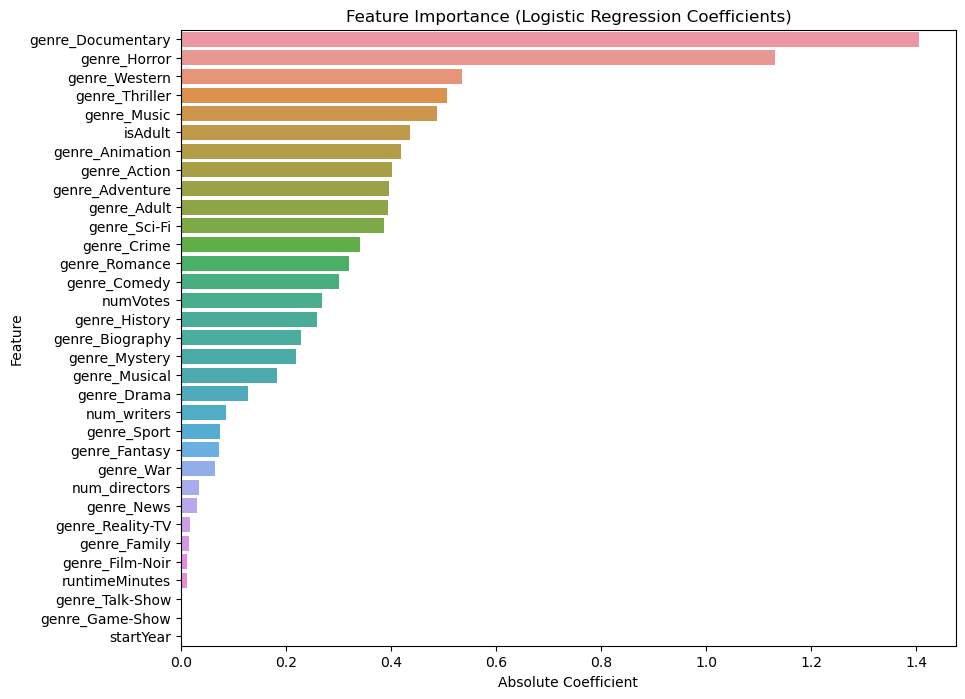

In [ ]:
# Plotting the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Absolute Coefficient', y='Feature', data=importance_df)
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.show()

Key Features: The top features in terms of absolute coefficient values are genre_Documentary, genre_Horror, and genre_Western. These features have the strongest impact on the target variable.

Decision Making: Depending on the goal (e.g., improving a movie's chances for an award, optimizing marketing strategies), you can focus on the influential genres.

In [ ]:
# Reduce the background data to a manageable size using random sampling
background_sample = shap.sample(X_train, 100)

# Initialize the SHAP explainer with the sampled background data
explainer = shap.KernelExplainer(best_log_reg.predict, background_sample)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

  0%|          | 0/72973 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Partial dependence plot for Logistic Regression
PartialDependenceDisplay(best_log_reg, X_train, features=[0, 1, 2, 3, 4])
plt.suptitle('Partial Dependence Plot (Logistic Regression)')
plt.subplots_adjust(top=0.9)
plt.show()

### XGBoost

In [ ]:
# XGBoost with hyperparameter tuning
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the parameter grid
param_grid_xgb = {
    'xgb__n_estimators': [100, 200],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 5, 7],
    'xgb__colsample_bytree': [0.3, 0.7]
}

# Grid search for XGBoost
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='accuracy')
grid_search_xgb.fit(X_train, y_train)

# Best parameters and score
print("Best parameters for XGBoost: ", grid_search_xgb.best_params_)
print("Best cross-validation accuracy: ", grid_search_xgb.best_score_)

# Predict and evaluate on the test set
y_pred_xgb = grid_search_xgb.predict(X_test)
print("Test Accuracy: ", accuracy_score(y_test, y_pred_xgb))
print("Classification Report: \n", classification_report(y_test, y_pred_xgb))

NameError: name 'xgb' is not defined

#### Understanding the Model: XGBoost

In [ ]:
# Extracting the best XGBoost model from GridSearchCV
best_xgb = grid_search_xgb.best_estimator_

# Feature importances
importances = best_xgb.feature_importances_
feature_names = X.columns

# Creating a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sorting by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Absolute Coefficient', y='Feature', data=importance_df)
plt.title('Feature Importance (XGBoost)')
plt.show()

In [ ]:
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(best_xgb)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

In [ ]:
# Partial dependence plot for XGBoost
PartialDependenceDisplay(best_xgb, X_train, features=[0, 1, 2, 3, 4])
plt.suptitle('Partial Dependence Plot (XGBoost)')
plt.subplots_adjust(top=0.9)  # Adjust top to fit title
plt.show()

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform Grid Search to find the best parameters
grid_search_rf.fit(X_train, y_train)

# Best parameters and score
print("Best parameters for Random Forest: ", grid_search_rf.best_params_)
print("Best cross-validation accuracy: ", grid_search_rf.best_score_)

# Predict and evaluate on the test set
y_pred_rf = grid_search_rf.predict(X_test)
print("Test Accuracy: ", accuracy_score(y_test, y_pred_rf))
print("Classification Report: \n", classification_report(y_test, y_pred_rf))

#### Understanding the Model: Random Forests

In [ ]:
# Extracting the best Random Forest model from GridSearchCV
best_rf = grid_search_rf.best_estimator_

# Feature importances
importances = best_rf.feature_importances_
feature_names = X.columns

# Creating a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sorting by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

In [ ]:
# Plotting feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance (Random Forest)')
plt.show()

In [ ]:
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(best_rf)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type='bar')

In [ ]:
# Partial dependence plot for Random Forest
PartialDependenceDisplay(best_rf, X_train, features=[0, 1, 2, 3, 4])
plt.suptitle('Partial Dependence Plot (Random Forest)')
plt.subplots_adjust(top=0.9)  # Adjust top to fit title
plt.show()